# Response Timing from Telegram HTML Export

This notebook computes response times between two users using a Telegram Desktop/Lite HTML export.
Set the export path and the two participant names below.

In [10]:
from pathlib import Path
from statistics import median, mean

from message_analyser.retriever.telegram_html import get_mymessages_from_html

# Required: path to the export folder or messages.html
export_path = "/Users/danuhaha/Downloads/Telegram Lite/ChatExport_2025-09-20"  # e.g., '/Users/me/Downloads/ChatExport_2025-09-21'

# Required: names must match how they appear in the export
your_name = "Даня Горин"
target_name = "Ваня"

assert Path(export_path).exists(), f'Export path not found: {export_path}'


In [11]:
# Load messages from HTML export and build a simplified history: (date, is_out, text)
msgs = get_mymessages_from_html(export_path, your_name, target_name)

def _norm(s):
    return (s or '').strip().casefold()
_me = _norm(your_name)
_tgt = _norm(target_name)

# Mark your messages by case-insensitive author match
timestamps_history = [(msg.date, _norm(msg.author)==_me, msg.text or '') for msg in msgs]
print(f'Total messages: {len(timestamps_history)}; first: {timestamps_history[0][0]}; last: {timestamps_history[-1][0]}')



2025-09-22 19:31:52,773 - 38688 messages parsed from Telegram HTML export at /Users/danuhaha/Downloads/Telegram Lite/ChatExport_2025-09-20



Total messages: 38688; first: 2024-09-16 20:56:54; last: 2025-09-20 22:41:08


In [16]:
# Split consecutive messages into replicas per author in chronological order
def split_history_into_replicas(history):
    replicas = []
    if not history:
        return replicas
    current = [history[0]]
    current_is_out = history[0][1]
    for item in history[1:]:
        if item[1] == current_is_out:
            current.append(item)
        else:
            replicas.append(current)
            current = [item]
            current_is_out = item[1]
    replicas.append(current)
    return replicas

replicas = split_history_into_replicas(timestamps_history)
print('Replicas:', len(replicas))


Replicas: 19357


In [20]:
# Compute response time deltas between alternating replicas (focus on questions ending with '?')
her_diffs = []   # partner response time to your questions (seconds)
my_diffs = []    # your response time to partner's questions (seconds)

for i in range(len(replicas) - 1):
    first_next = replicas[i + 1][0]
    last_current = replicas[i][-1]
    diff_sec = int((first_next[0] - last_current[0]).total_seconds())
    if diff_sec < 0:
        # Should not happen if history is chronological, but guard anyway
        continue
    last_text = last_current[2] or ''
    if '?' in last_text:
        if last_current[1] and not first_next[1]:
            her_diffs.append(diff_sec)
        elif (not last_current[1]) and first_next[1]:
            my_diffs.append(diff_sec)

print('Samples -> Ваня:', len(her_diffs), 'Я:', len(my_diffs))


Samples -> Ваня: 1320 Я: 594


In [21]:
# Build coarse distributions (same shape as original) and basic stats
def build_distribution(data, step, left_th, right_th):
    new_data = [ts for ts in data if left_th <= ts <= right_th]
    if not new_data:
        return []
    bins = max(new_data) // step + 1
    dist = [0] * bins
    for x in new_data:
        dist[x // step] += 1
    log_dist = []
    i = 0
    bin_size = 1
    while i < len(dist):
        next_i = i + int(max(1, bin_size))
        res = 0
        while i < next_i and i < len(dist):
            res += dist[i]
            i += 1
        log_dist.append(res)
        bin_size *= 1.1
    for i in range(len(log_dist)):
        log_dist[i] /= len(new_data)
    return log_dist

def filter_th(dt, left_th, right_th):
    return [x for x in dt if left_th <= x <= right_th]

step = 1
left_threshold = 0
right_threshold = 200000
right_slice = 5000

her_dists = build_distribution(her_diffs, step, left_threshold, right_threshold)[:right_slice]
my_dists = build_distribution(my_diffs, step, left_threshold, right_threshold)[:right_slice]

def get_label_by_sec(sec):
    ss = sec % 60
    mm = (sec // 60) % 60
    hh = sec // 3600
    if hh > 0:
        return f'{hh}h'
    if mm > 0:
        return f'{mm}m'
    if ss > 0:
        return f'{ss}s'
    return '0s'

x = []
labels = []
k = 1.1
bin_size = 1
curr = 0
last_label = -10
for i in range(100):
    if last_label + 5 < i:
        x.append(i)
        labels.append(get_label_by_sec(int(curr)))
        last_label = i
    curr += bin_size
    bin_size *= k

print(
    f'{target_name}: его медиана:', median(filter_th(her_diffs, left_threshold, right_threshold)),
    f' моя медиана:', median(filter_th(my_diffs, left_threshold, right_threshold))
)
print(
    f'{target_name}: его среднее:', mean(filter_th(her_diffs, left_threshold, right_threshold)),
    f' мое среднее:', mean(filter_th(my_diffs, left_threshold, right_threshold))
)


Ваня: его медиана: 33.0  моя медиана: 34.0
Ваня: его среднее: 355.26363636363635  мое среднее: 474.2929292929293


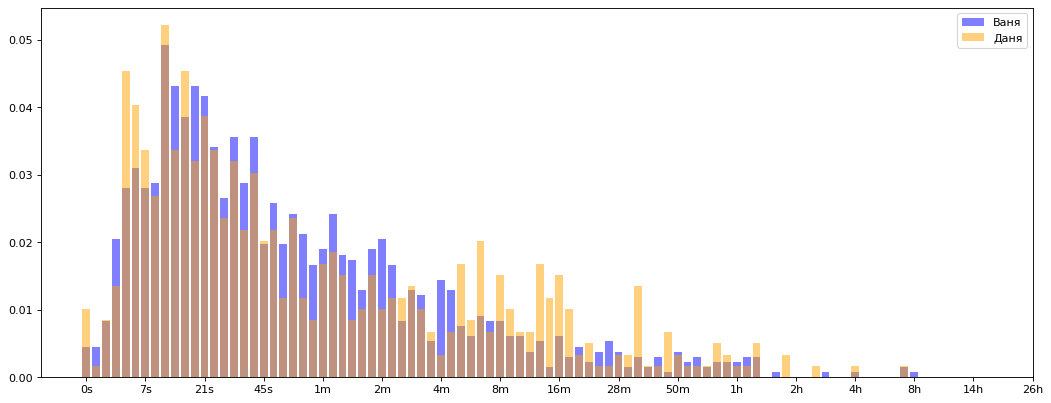

In [23]:
# Plot distributions (bars, as in the original)
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.bar([i for i in range(len(her_dists))], her_dists, color='blue', alpha=0.5)
plt.bar([i for i in range(len(my_dists))], my_dists, color='orange', alpha=0.5)
plt.xticks(x, labels, rotation='horizontal')
plt.legend(['Ваня', 'Даня'])
plt.show()
